# Imports

In [1]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns
import copy
import requests
from bs4 import BeautifulSoup
from datetime import date, timedelta
from time import sleep
from random import random
from os.path import exists
from os import mkdir
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from tqdm import tqdm
from time import mktime

# Function Definitions

In [2]:
def getTicker(searchterm):
    head = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'}
    #searchterm = input()
    queryurl = 'https://www.google.com/search?q='+searchterm+'+stock'
    page = requests.get(queryurl,headers=head)
    soup = BeautifulSoup(page.text, 'html.parser')
    res = soup.find('div', class_="iAIpCb PZPZlf")
    if res != None:
        return res.text.split()[1]
    return None

In [3]:
def wsj_extractor(html):
    headlines = list()
    soup = BeautifulSoup(html, 'html.parser')
    sectionlist = soup.find_all('div', class_='WSJTheme--overflow-hidden--qJmlzHgO')
    for section in sectionlist:
        art = section.find('span', class_='WSJTheme--headlineText--He1ANr9C')
        headlines.append(art.text)
    return headlines

def tbs_extractor(html):
    headlines = list()
    date_exception = re.compile('\d\d-\d\d-\d\d\d\d')
    soup = BeautifulSoup(html, 'html.parser')
    sectionlist = soup.find_all('h4', class_='card-title')
    for section in sectionlist:
        art = section.find('a').text
        if not date_exception.match(art):
            headlines.append(art)
    return headlines

def nyt_extractor(html):
    headlines = list()
    soup = BeautifulSoup(html, 'html.parser')
    sectionlist = soup.find_all('h2', class_='css-ds6ff4 e1b0gigc0')
    for section in sectionlist:
        headlines.append(section.text)
    return headlines

# Parameter Definition

In [16]:
head = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'}
today = date.today()
oneday = timedelta(days=1)
print(today)

sources = ['wsj','tbs','nyt']

urls =    {'wsj': lambda day: 'https://www.wsj.com/news/archive/'+day.strftime('%Y/%m/%d'),
           'tbs': lambda day: 'https://www.tbsnews.net/archive/'+day.strftime('%Y/%m/%d'),
           'nyt': lambda day: 'https://www.nytimes.com/issue/todaysheadlines/'+day.strftime('%Y/%m/%d')+'/todays-headlines'}
extractors = {'wsj': wsj_extractor,
              'tbs': tbs_extractor,
              'nyt': nyt_extractor}

analyzer = SentimentIntensityAnalyzer()

num_years = 3
searchterm = input('Enter stock: ').casefold()

2023-07-05


Enter stock:  facebook


# Scraping

In [17]:
for src in sources:
    if not exists(src):
        mkdir(src)
        
#search_score_list = list()
#score_df = pd.DataFrame(columns = ['Score','Date']).set_index('Date')
        
if exists('stock_sent_data.csv'):
    news_df = pd.read_csv('stock_sent_data.csv')
    news_df.date = pd.to_datetime(news_df.date)
else:
    news_df = pd.DataFrame(columns = ['title','date','source'])
    
day = today+oneday
#last_idx = len(news_df.index)
new_arts = list()
for i in tqdm(range(int(num_years*365)), desc = 'Scraping...'):
    day = day - oneday
    pday = pd.to_datetime(day)
    wait = False
    for src in sources:
        if src not in news_df.loc[(news_df['date'] == pday)]['source'].values:
            fileurl = src+'/'+str(day)+'.html'
            if not exists(fileurl):
                url = urls[src](day)
                html = requests.get(url, headers = head)
                try:
                    html.raise_for_status()
                    with open(fileurl, 'wb+') as f:
                        f.write(html.content)
                    #sleep(0.5+random())
                    wait = True
                except:
                    print('failed at: '+str(day)+' for '+src)
                    continue
            with open(fileurl, 'rb') as f:
                html = f.read()
            for headline in extractors[src](html) or []:
                #last_idx+=1
                #news_df.loc[last_idx] = [headline, pday, src]
                new_arts.append([headline, pday, src])

    if wait:
        sleep(random())
news_df = pd.concat([news_df, pd.DataFrame(new_arts, columns = ['title','date','source'])])        
news_df = news_df.sort_values('date').reset_index(drop=True)
news_df.to_csv('stock_sent_data.csv', index = False)

Scraping...: 100%|████████████████████████████████████████████████████████████████| 1095/1095 [00:02<00:00, 483.75it/s]


# Analyzing

In [18]:
day = today+oneday
news_df = pd.read_csv('stock_sent_data.csv')
search_score_list = list()
score_df = pd.DataFrame(columns = ['Score','Date']).set_index('Date')
for i in tqdm(range(int(num_years*365)), desc='Scoring...'):    
    day = day - oneday
    pday = pd.to_datetime(day)
    day_df = news_df.loc[(news_df['date'] == pday)]['title']
    score = 0
    for article in day_df:
        if not article:
            continue
        num_matches = 0
        if searchterm in article.casefold():
            score+= analyzer.polarity_scores(article)['compound']
            num_matches+= 1
        if num_matches != 0:
            score/=num_matches
    score_df.loc[pday] = [score]

Scoring...: 100%|██████████████████████████████████████████████████████████████████| 1095/1095 [00:14<00:00, 76.70it/s]


# Stock Data Retrieval

In [19]:
stock = yf.Ticker(getTicker(searchterm))
stock_df = stock.history(period=str(num_years)+'y')

stock_df = stock_df.loc[:,['Open', 'High', 'Low', 'Close']]
stock_df.index = stock_df.index.tz_localize(None)

# ML Model Building

In [20]:
def stockpipe(stock_df, score_df, given_size=None):
    Scaler = StandardScaler()
    scaled_df = Scaler.fit_transform(stock_df)

    interval = 30

    stock_df = pd.DataFrame(scaled_df, columns = stock_df.columns, index=stock_df.index.tz_localize(None))
    #print("Scaled Dataframe: \n",df)
    stock_columns = stock_df.columns
    date_index = stock_df.index

    df = stock_df.join(score_df['Score']).fillna(0)

    df.reset_index(drop=True, inplace=True)

    sequences = []
    labels = []
    start_idx = 0
    for stop_idx in range(interval, len(df)-1):
        sequences.append(df.loc[start_idx:stop_idx])
        labels.append(df.loc[stop_idx+1])
        start_idx += 1
    #return np.array(sequences), np.array(labels)

    sequences = np.array([[[float(x) for x in list ]for list in blist] for blist in np.array(sequences)])
    labels = np.array([[float(y) for y in blist ] for blist in np.array(labels)])

    # print(len(sequences))
    # print(len(labels))
    # for i in range(len(sequences)):
    #   print(sequences[i], ":   ", labels[i])

    if given_size != None:
        train_size = int(given_size * len(sequences))
        trainX = sequences[:train_size]
        trainY = labels[:train_size]
        testX = sequences[train_size:]
        testY = labels[train_size:]

        trainY = np.delete(trainY, -1, 1)
        testY = np.delete(testY, -1, 1)

        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
        model.add(Dropout(0.1)) 
        model.add(LSTM(units=50))
        model.add(Dense(trainX.shape[2]-1))

        # model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.summary()
        model.fit(trainX, trainY, epochs=100, batch_size=None) #epochs ought to be 20+ I guess

        #Prediction
        predY = model.predict(testX)
     
        series_plus_one = testX[-1]
        series_plus_one = np.delete(series_plus_one, 0, 0)
        series_plus_one = np.vstack([series_plus_one, np.hstack([predY[-1],np.array([0])])])
        plus_one_Y = model.predict(np.array([series_plus_one]))
        plus_one_Y = Scaler.inverse_transform(plus_one_Y)

        next_day_df = pd.DataFrame(plus_one_Y, columns = stock_columns)
        print('\nNext day\'s predicted values: \n', next_day_df)
    
        predY = Scaler.inverse_transform(predY)
        rmse = np.sqrt(np.mean((predY - Scaler.inverse_transform(testY))**2))
        print('\nRoot Mean Squared Error (RMSE):', rmse,"\n\n")

        pred_df = pd.DataFrame(predY, columns = stock_columns, index = date_index[-len(predY):])
        #print("Length of pred_df",len(pred_df))
        #print(pred_df)

        test_arr = Scaler.inverse_transform(testY)
        testplot_df = pd.DataFrame(test_arr, columns = stock_columns, index = date_index[-len(pred_df):])
        #print("Length of testplot_df",len(testplot_df))
        #print(testplot_df)

        plotting_column = 'High'
        #sns.lineplot(x = date_index[(len(trainX)+31):], y = pred_df[plotting_column], color='blue')
        #sns.lineplot(x = date_index[(len(trainX)+31):], y = testplot_df[plotting_column], color='orange')
        plt.figure(figsize=(10,6))
        sns.lineplot(x = pred_df.index, y = pred_df[plotting_column], color='cyan')
        sns.lineplot(x = testplot_df.index, y = testplot_df[plotting_column], color='orange')
        plt.xticks(rotation=50)
        #plt.legend(loc=2, labels=['predicted', 'actual'])
        plt.grid()

        #df = Scaler.inverse_transform(df)
        #df = pd.DataFrame(df, columns = stock_columns, index=date_index)
        return df, date_index, testplot_df, pred_df

    return df, date_index

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 31, 50)            11200     
                                                                 
 dropout_2 (Dropout)         (None, 31, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 4)                 204       
                                                                 
Total params: 31,604
Trainable params: 31,604
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
20/20 [==============================] - 3s 16ms/step - loss: 0.3686
Epoch 2/100
20/20 [==============================] - 0s 15ms/step - loss: 0.0768
Epoch 3/100
20/20 [=

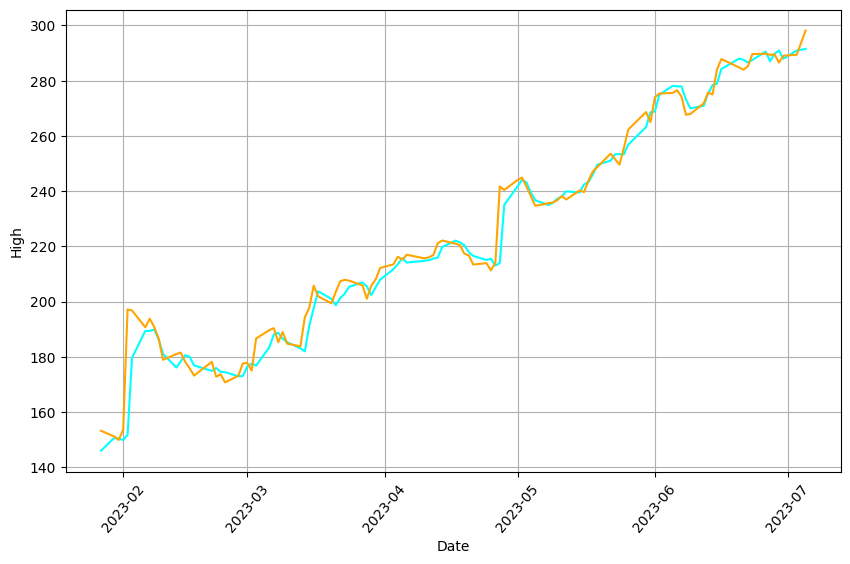

In [21]:
eg_df, date_index, pred_df, testplot_df = stockpipe(stock_df, score_df,given_size=0.85)

In [22]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

merged_df = pd.merge(pred_df, testplot_df, on=pred_df.index)

#mape_1 = mean_absolute_percentage_error(merged_df['High_x'], merged_df['High_y'])
#mape_2 = mean_absolute_percentage_error(merged_df['Open_x'], merged_df['Open_y'])
r2_1 = r2_score(merged_df['High_x'], merged_df['High_y'])
r2_2 = r2_score(merged_df['Open_x'], merged_df['Open_y'])

#print(f"MAPE for daily High: {mape_1:.2f}")
#print(f"MAPE for Opening price: {mape_2:.2f}")
print(f"R2 score for daily High: {r2_1:.5f}")
print(f"R2 score for Opening price: {r2_2:.5f}")


R2 score for daily High: 0.97347
R2 score for Opening price: 0.97822


# Alternative Scraper-Analyzer:
No long term storage requirements but consistently needs more time
> Turnaround time can be improved at risk of being IP banned

In [ ]:
day = today+oneday
search_score_list = list()
score_df = pd.DataFrame(columns = ['Score','Date']).set_index('Date')
for i in tqdm(range(int(num_years*365)), desc='Scoring...'):    
    day = day - oneday
    pday = pd.to_datetime(day)
    url = 'https://timesofindia.indiatimes.com/topic/'+searchterm+'/news?dateFilter='+str(mktime(day.timetuple())*1000)+','+str(mktime(day.timetuple())*1000-86400)
    html = requests.get(url, headers = head)
    headlines = list()
    soup = BeautifulSoup(html.text, 'html.parser')
    title_list = soup.find_all('div', class_='fHv_i o58kM')
    #blurb_list = soup.find_all('p', class_='oxXSK o58kM')
    for title in title_list:
        art = title.find('span')
        headlines.append(art.text)
    #day_df = news_df.loc[(news_df['date'] == pday)]['title']
    score = 0
    for article in headlines:
        if not article:
            continue
        num_matches = 0
        if searchterm in article.casefold():
            score+= analyzer.polarity_scores(article)['compound']
            num_matches+= 1
        if num_matches != 0:
            score/=num_matches
    score_df.loc[pday] = [score]
    sleep(random())